# 2D Segmentation Tensorflow

# Check GPU Properties

In [ ]:
import torch
import warnings
warnings.filterwarnings("ignore")
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

# Import Libraries

In [3]:
import os
import gc
import cv2
import h5py
import scipy
import random
import shutil
import pickle
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import PIL.Image
from tqdm import tqdm
import tensorflow as tf
from scipy import interp
import albumentations as A
from itertools import cycle
from tensorflow import keras
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Main

## Import and Preprocess Data

General Instructions:

*   If your Data is in a ZIP/RAR/TAR File, start from Step 1. If no preprocessing is required, skip all steps and directly go for model building.
*   Step 1 does not require "Data Configurations".
*   If your data is raw or requires some preprocessing before fold creation, move to Step 2.
*   If you require to create folds, go to Step 3, skip otherwise.
*   If you require to Augment Images, mainly in the Training Set, follow Step 4.
*   Visualize any image from any fold from the Train/Test/Validation set.







### Step 1: Import and UnZip/UnRaR/UnTar Files based on the Name and File-type

In [20]:
!gdown --id 1GtmdmZaYcJGAUgRKC5gGw73nuqoo0k3c # Import Data

/bin/bash: line 1: gdown: command not found


UnZIP for ZIP Files

In [21]:
!jar xvf Data.zip

UnRAR for RAR Files

In [ ]:
# !unrar x "input_file_name.rar" "/content/"

UnTAR for TAR Files

In [ ]:
# !tar -xvf "input_file_name.tar" -C "/content/"  #[run this cell to extract tar files]
# !tar -xzvf "input_file_name.tar.gz" -C "/content/"  #[run this cell to extract tar.gz files]
# !tar -xjvf "input_file_name.tar.bz2" -C "/content/"  #[run this cell to extract tar.bz2 files]

### Step 2: Preprocess Raw Data

If any "Module not Found' error, Upgrade 'albumentations' library to the latest version and restart runtime  
[Augmentation List from 'albumentations' GitHub](https://github.com/albumentations-team/albumentations#benchmarking-results)

In [ ]:
# !pip install albumentations --upgrade

Mention the Data Path for Raw Data and provide with a list of processing or augmentation steps, a sample is provided

In [ ]:
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE

# ADD NEW SECTION AND SETTINGS
config_file["DATA"]={
        "raw_data_path": 'Data/Test',  # Directory containing Raw Data
        }

# SAVE THE SETTINGS TO THE FILE
with open("Train Configurations.ini","w") as file_object:
    config_file.write(file_object)

In [ ]:
# PRINT FILE CONTENT
read_file = open("Train Configurations.ini", "r")
content = read_file.read()
print("Content of the config file are:\n")
print(content)
read_file.flush()
read_file.close()

Content of the config file are:

[DATA]
raw_data_path = Data/Test




In [ ]:
'Configurations'
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE
raw_data_path = config_file["DATA"]["raw_data_path"]  # EXTRACT VALUE

'List of Processes to be applied per image, vary it according to the requirements'
process_list = [A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
                ]

In [ ]:
def preprocess_rawdata(raw_data_path, process_list):
    num_folds = len(os.listdir(raw_data_path))
    for i in range(1, num_folds + 1):
        print(f'\nCurrently Processing Fold {i}')
        # List containing all images of a certain class in a certain fold
        Image_List = sorted(os.listdir(f'{raw_data_path}/Fold_{i}/Images/'))
        transform = A.Compose(process_list)
        for ii in range(0, (len(Image_List))):
            current_image = Image_List[ii]
            current_image = current_image[0:-4]
            # Read an image with OpenCV and convert it to the RGB colorspace
            org_image = cv2.imread(f'{raw_data_path}/Fold_{i}/Images/{Image_List[ii]}')  # Read Original Image
            img_nparray = np.asarray(org_image)
            if img_nparray.shape[2] > 3:
                org_image = org_image[:,:,:3]  # Remove Alpha (4th) Channel from the Image
            org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB Colorspace
            transformed_GT = transform(image=org_image)  # Augment Image and Corresponding Mask
            transformed_image = transformed_GT['image']
            cv2.imwrite(f'{raw_data_path}/Fold_{i}/Images/{current_image}.png', transformed_image)
            print(f'Image Number: {ii+1}')

In [ ]:
# from Helper_Functions import preprocess_rawdata
preprocess_rawdata(raw_data_path, process_list)

### Step 3: Create Folds from Raw Data

Create 'n' Folds from the Raw Dataset, this code only creates random stratification

In [ ]:
'Configurations'
config_file = configparser.ConfigParser()  # CREATE OBJECT 
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE
raw_data_path = config_file["DATA"]["raw_data_path"]  # Raw Data Directory, change the name accordingly
num_folds = config_file["DATA"]["num_folds"]  # Number of Folds required
train_portion = config_file["DATA"]["train_portion"]  # % of Data to be put in the training set, rest in the test set
val_portion = config_file["DATA"]["val_portion"]  # % of Train Data to be used for validation; optional parameter

In [ ]:
create_folds(raw_data_path, num_folds, train_portion, validation_portion=val_portion)

Creating Fold 1


100%|██████████| 4/4 [01:46<00:00, 26.73s/it]


Creating Fold 2


100%|██████████| 4/4 [01:36<00:00, 24.21s/it]


Creating Fold 3


100%|██████████| 4/4 [01:44<00:00, 26.04s/it]


Creating Fold 4


100%|██████████| 4/4 [01:39<00:00, 24.86s/it]


Creating Fold 5


100%|██████████| 4/4 [01:53<00:00, 28.33s/it]


### Step 4: Augment Data

If any "Module not Found' error or ValueError occurs, upgrade 'albumentations' library to the latest version and restart runtime

In [ ]:
!pip install albumentations --upgrade

[Augmentation List from 'albumentations' GitHub](https://github.com/albumentations-team/albumentations#benchmarking-results)

In [ ]:
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE

# ADD NEW SECTION AND SETTINGS
config_file["DATA"]={
        "raw_data_path": 'Data/Train',  # Directory containing Raw Data
        "augment_data_path": 'Data/Train',  # Directory for the Images to be Augmented
        "augmentation_num": 10  # Number of Augmentations per image
        }

# SAVE THE SETTINGS TO THE FILE
with open("Train Configurations.ini","w") as file_object:
    config_file.write(file_object)

[]

In [ ]:
'Configurations'
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE
augment_data_path = config_file["DATA"]["augment_data_path"]  # Augmentation is normally done on the Train Data but Test and Validation sets can be processed as well (e.g., resize) by changing the directory
augmentation_num = int(config_file["DATA"]["augmentation_num"])  # Number of Augmentations per Image

'List of Augmentations to be applied per image, vary it according to the requirements'
augmentation_list = [A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
                     A.Rotate(limit=90, interpolation=1, border_mode=4, p=1.0),
                     A.Flip(p=0.5),
                     A.Transpose(p=0.5),
                     # A.RandomSizedCrop(min_max_height=[384,384], height=512, width=512, p=0.5),
                ]

'Configurations'

['Train Configurations.ini']

'List of Augmentations to be applied per image, vary it according to the requirements'

Augment Images

In [ ]:
def augment_segmentation_data(data_path, augmentation_list, augmentation_num):
    num_folds = len(os.listdir(data_path))
    # Declare an Augmentation Pipeline
    for i in range(1, num_folds + 1):
        print(f'\nCurrently Processing Fold {i}')
        # List containing all images of a certain class in a certain fold
        Image_List = sorted(os.listdir(f'{data_path}/Fold_{i}/Images/'))
        Mask_List = sorted(os.listdir(f'{data_path}/Fold_{i}/Masks/'))
        for ii in range(0, (len(Mask_List))):
            current_image = Image_List[ii]
            current_image = current_image[0:-4]
            current_mask = Mask_List[ii]
            current_mask = current_mask[0:-4]
            # Read an image with OpenCV and convert it to the RGB colorspace
            org_image = cv2.imread(f'{data_path}/Fold_{i}/Images/{Image_List[ii]}')  # Read Original Image
            corresponding_mask = cv2.imread(f'{data_path}/Fold_{i}/Masks/{Mask_List[ii]}')  # Read Original Image
            img_nparray = np.asarray(org_image)
            if img_nparray.shape[2] > 3:
                org_image = org_image[:,:,:3]  # Remove Alpha (4th) Channel from the Image
            org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB Colorspace
            msk_nparray = np.asarray(corresponding_mask)
            if msk_nparray.shape[2] > 1:
                corresponding_mask = corresponding_mask[:,:,0]  # Convert masks to Grayscale images from RGB
            for iv in range(1, augmentation_num + 1):
                transform = A.Compose(augmentation_list)
                transformed_GT = transform(image=org_image, mask=corresponding_mask)  # Augment Image and Corresponding Mask
                transformed_image = transformed_GT['image']
                transformed_mask = transformed_GT['mask']
                cv2.imwrite(f'{data_path}/Fold_{i}/Images/{current_image}_Augmented_{iv}.png', transformed_image)
                cv2.imwrite(f'{data_path}/Fold_{i}/Masks/{current_mask}_Augmented_{iv}.png', transformed_mask)
            print(f'Image Number: {ii+1}')

In [ ]:
# from Helper_Functions import augment_segmentation_data
augment_segmentation_data(augment_data_path, augmentation_list, augmentation_num)

### Check and Visualize Images

In [ ]:
# Open the image form working directory
image_path = '/content/Data/Train/Fold_1/Images/1.2.392.200036.9116.6.23.10552866.1142.20210815074059931.1.433.png'
mask_path = '/content/Data/Train/Fold_1/Masks/1.2.392.200036.9116.6.23.10552866.1142.20210815074059931.1.433.png'
# load and show an image with Pillow
image = PIL.Image.open(image_path)
print(image.mode)
# convert image to numpy array
data = np.asarray(image)
print(type(data))  # Type of the Image (e.g., RGB, BGR or RGBA)
# summarize shape
print(data.shape)  # Shape of the Images
print(np.max(data[:,:]))  # Compute Pixel information

RGB
<class 'numpy.ndarray'>
(512, 512, 3)
255


In [ ]:
# load and show an image with Pillow
image = PIL.Image.open(mask_path)
print(image.mode)
# convert image to numpy array
data = np.asarray(image)
print(type(data))  # Type of the Image (e.g., RGB, BGR or RGBA)
# summarize shape
print(data.shape)  # Shape of the Images
print(np.max(data[:,:]))  # Compute Pixel information

L
<class 'numpy.ndarray'>
(512, 512)
255


Plot Images

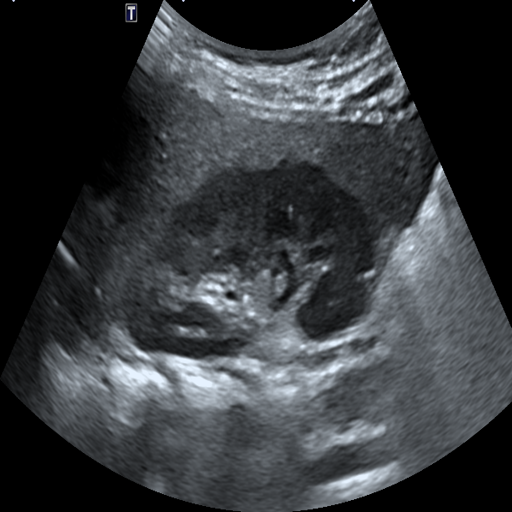

In [ ]:
from google.colab.patches import cv2_imshow  # This is used to display images in COLAB using cv2
image = cv2.imread(image_path)
cv2_imshow(image)

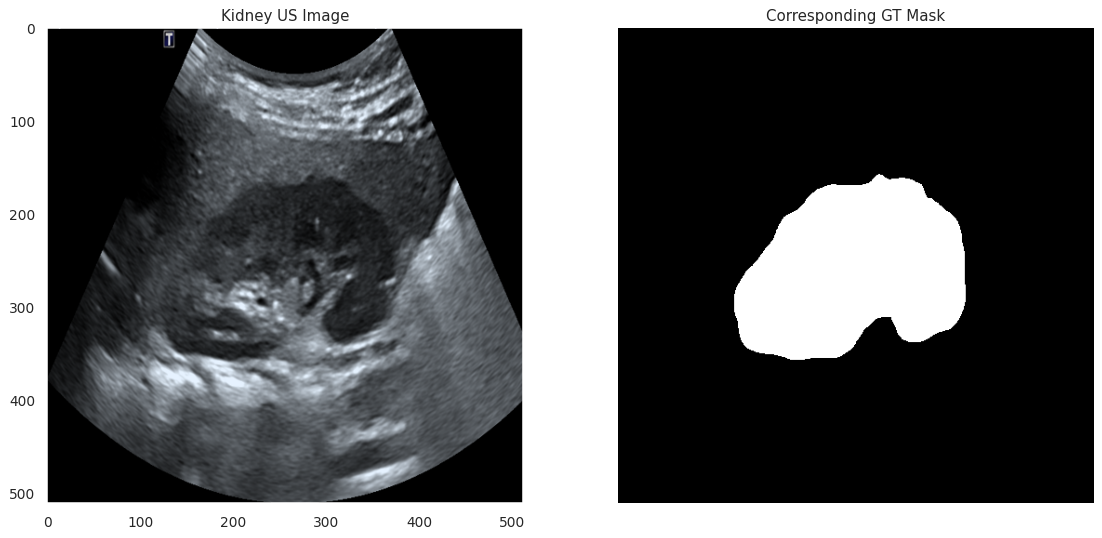

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(15, 8), dpi=90)

image1 = plt.imread(image_path, cv2.IMREAD_UNCHANGED)
image2 = plt.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.subplot(1, 2, 1), plt.imshow(image1, 'gray')
plt.grid(False)
plt.title(f"Kidney US Image")
plt.subplot(1, 2, 2), plt.imshow(image2, 'gray')
plt.title(f"Corresponding GT Mask")
plt.axis('off')
plt.show() # To show figure

## Train

### Train Configurations

**Available 2D-Segmentation Models:**  

**--- UNet Variants ---**
* **UNet**
* **Ensemble UNet (UNetE)**
* **UNet+**
* **UNet++**
* **UNet3+**
* **UNet4+**
* **AHNet**
* **KSSNet**
* **MultiResUNet**
* **MultiResUNet3+**
* **Self-UNet**
* **Self-UNet++**
* **Self-UNet3+**  

**--- FPN Variants ---**
* **FPN**
* **MultiResFPN**
* **Self-FPN**

**Supported PreTrained Encoders:**
* **ResNet:** ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2 (ImageNet)
* **VGG:** VGG16, VGG19 (ImageNet)
* **DenseNet:** DenseNet121, DenseNet169, DenseNet201 (ImageNet)
* **MobileNet:** MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large (ImageNet)
* **Inception:** InceptionV3, InceptionResNetV2 (ImageNet)
* **EfficientNetV1:** EfficientNetB[0-7] (ImageNet)
* **EfficientNetV2:** EfficientNetV2B[0-3], EfficientNetV2S, EfficientNetV2M, EfficientNetV2L (ImageNet)
* **CheXNet** (Custom)

**Supported Loss Functions:** Check "tf_losses.py" file  
**Supported Optimizers:** Check "tf_optimizers.py" file  
**Supported Metrics:** Check "tf_metrics.py" file  

In [4]:
# CREATE OBJECT
config_file = configparser.ConfigParser()

# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
        ## Data Configurations
        "train_dir": "Data/Train",  # Train Directory
        "val_dir": "Data/Val",  # Validation Directory
        "data_loading_mode": "Custom_DataLoader",  # TF_DataLoader: Use TensorFlow DataLoader | Custom_DataLoader: Use Custom DataLoader
        "independent_val_set": True,  # True: Independent Validation Set | False: Validation Set randomly splitted from the Training Set
        "validation_portion": 0.0,  # 0 to 1 [Default: 0; when validation set is independent, otherwise created randomly while training based on "validation_portion"]
        "imlength": 512,  # Length or Height of the Image | Image Size: [imwidth, imlength]
        "imwidth": 512,  # Width of the Image
        "image_color_mode": "rgb",  # Color Mode of the images [rgb, rgba (rgb with transparent alpha channel), grayscale (black and white single channel image)]
        "mask_color_mode": "grayscale",  # Color Mode of the masks [rgb or grayscale (black and white single channel image)]
        "num_channels": 3,  # Number of Input Channels in the Model [rgb:3, rgba:4, grayscale:1]
        "normalizing_factor_img": 255,  # 255.0 for images with pixel values varying between 0 to 255. If it is between 0 to 1, change it to 1
        "normalizing_factor_msk": 255,  # 255 for masks with pixel values varying between 0 to 255. If it is between 0 to 1, change it to 1
        ## Model Configurations
        "model_genre": "FPN",  # model_genre: Generation or Genre of the Model: UNet, FPN, LinkNet, etc.
        # Encoder
        "encoder_mode": "from_scratch",  # Transfer Learning: "pretrained_encoder" | Train from scratch: "from_scratch"
        "encoder_name": "ResNet50",  # Select an Encoder from a pool of ImageNet trained Models available from TensorFlow, default: ResNet50
        "encoder_trainable": False,  # Fine Tuning ON/OFF [True/False] | Start with OFF, Fine Tune later in the 2nd stage, which is optional
        # Decoder
        "decoder_name": "FPN",  # Select a Model from the list to train from scratch, UNet is kept as default
        "model_width": 16,  # Number of Filters or Kernels of the Input Layer, subsequent layers start from here
        "model_depth": 5,  # Number of Layers in the Model [For the "pretrained_encoder" mode: Maximum 5, Minimum 1]
        "output_nums": 1,  # Number of Outputs for the model
        "A_E": 0,  # Turn on AutoEncoder Mode for Feature Extraction [Default: 0]
        "A_G": 0,  # Turn on for Guided Attention [Default: 0]
        "LSTM": 0,  # Turn on for LSTM [Default: 0]
        "dense_loop": 2,  # Number of Densely Connected Residual Blocks in the BottleNeck Layer [Default: 2]
        "feature_number": 1024,  # Number of Features to be Extracted [Only required for the AutoEncoder (A_E) Mode]
        "is_transconv": True,  # True: Transposed Convolution | False: UpSampling in the Decoder layer
        "alpha": 1,  # Alpha parameter, required for MultiResUNet models [Default: 1]
        "q_onn": 3,  # 'q' for Self-ONN' [Default: 3, set 1 to get CNN]
        "final_activation": "sigmoid",  # Activation Function for the Final Layer: "Linear", "Sigmoid", "Softmax", etc. depending on the problem type
        "class_number": 1,  # Number of Output Classes [e.g., here for Kidney Tumor segmentation, Class 1: Kidney | Class 2: Tumor]
        ## Training Configurations
        "batch_size": 4,  # Batch Size of the Images being loaded for training
        "learning_rate": 0.0002,  # During Fine-Tuning the network, the Learning Rate should be very low (e.g., 1e-5), otherwise more (e.g., 1e-4, 1e-3)
        "start_fold": 5,  # Fold to Start Training, can be varied from 1 to the last fold
        "end_fold": 5,  # Fold to End Training, can be any value from the start_fold [Number of Folds + 1]
        "monitor_param": "val_mean_squared_error",  # Monitoring parameter during training
        "patience_amount": 20,  # Number of epochs to wait before training to stop
        "patience_amount_RLROnP": 10,  # Number of epochs to wait before training to stop
        "patience_mode": "min",  # patience mode: 'min', 'max' or 'auto'
        "RLROnP_factor": 0.1,  # Number of epochs to wait before training to stop
        "num_epochs": 200,  # Number of epochs for training
        "loss_function": "MeanSquaredLogarithmicError", # Loss Functions
        "optimizer_function": "Adam",  # Optimization Algorithm
        "metric_list": "MeanSquaredError",  # Metric(s) being monitored
        "save_history": True,  # Metric(s) being monitored
        "load_weights": True,  # Metric(s) being monitored
        "save_dir": "Results/Kidney",  # Metric(s) being monitored
        "task_name": "None",  # Metric(s) being monitored
        "seed": 1,  # SEED required for randomly split Validation set from the Training set, not used when "validation_portion"= 0.0
        # Patchify
        "patchify": False,  # Metric(s) being monitored
        "patch_width": 64,  # Length or Height of the Image | Image Size: [imwidth, imlength]
        "patch_height": 64,  # Width of the Image
        "overlap_ratio": 0,
        # Deep Supervision
        "D_S": 0,  # Turn on Deep Supervision [Default: 0]
        "ds_type": "UNet"  # "UNet" or "UNetPP"; only required when Deep Supervision (D_S) is on
        }
# SAVE CONFIG FILE
with open(r"Train_Configs.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()
print("Config file 'Train_Configs.ini' created")

Config file 'Train_Configs.ini' created


### Start Training

Major Flexible Training Loop Accross Folds

In [ ]:
%run -m train

### Fine-Tune Model (Optional)

Update Training Configurations for the Fine-Tuning Mode

In [ ]:
config = configparser.ConfigParser()
config.read('Train_Configs.ini')
config.set('TRAIN', 'encoder_trainable', 'True')
config.set('TRAIN', 'learning_rate', '0.00005')
config.set('TRAIN', 'patience_amount', '10')
config.set('TRAIN', 'num_epochs', '50')
config.set('TRAIN', 'save_history', 'False')

with open('Train_Configs.ini', 'w') as configfile:
    config.write(configfile)

Fine-Tune Model through Re-training
* Make sure a previously trained model is loaded
* Fine-tuning a previously trained model after unfreezing the previously frozen layers of the trained encoder should be done with a very low learning rate (e.g., 10X-20X lower than the original)

In [ ]:
%run -m train

## Inference

Set Test Configurations

In [9]:
import configparser

# CREATE OBJECT
config_file = configparser.ConfigParser()

# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
        ## Data Configurations
        "test_dir": "Data/Test",
        "imheight": 512,  # Size of the Images being Trained, they will be resized in this shape: [imsize, imsize]
        "imwidth": 512,  # Size of the Images being Trained, they will be resized in this shape: [imsize, imsize]
        "image_color_mode": "rgb",  # Color Mode of the images [rgb, rgba (rgb with transparent alpha channel), grayscale (black and white single channel image)]
        "mask_color_mode": "grayscale",  # Color Mode of the kmasks [rgb or grayscale (black and white single channel image)]
        "num_channels": 3,  # Number of Input Channels in the Model [rgb:3, rgba:4, grayscale:1]
        "class_number": 1,  # Number of Output Classes [e.g., here for Kidney Tumor segmentation, Class 1: Kidney | Class 2: Tumor]
        "labels": "",
        ## Model Configurations
        "encoder_mode": "from_scratch",  # Transfer Learning: "pretrained_encoder" | Train from scratch: "from_scratch"
        "encoder_name": "ResNet50", # Select an Encoder from a pool of ImageNet trained Models available from TensorFlow, default: ResNet50
        "decoder_name": "UNetPP",  # Select a Model from the list to train from scratch, ResNet50 is kept as default
        ## Test Configurations
        "batch_size": 4,  # Batch Size of the Images bein loaded for training
        "normalizing_factor_img": 255.0,  # 255.0 for images with pixel values varying between 0 to 255. If it is between 0 to 1, change it to 1
        "normalizing_factor_msk": 255.0,  # 255.0 for images with pixel values varying between 0 to 255. If it is between 0 to 1, change it to 1
        "start_fold": 1,  # Fold to Start Training, can be varied from 1 to the last fold
        "end_fold": 1,  # Fold to End Training, can be any value from the start_fold [Number of Folds + 1]
        "num_iter": 1,  # Number of Folds completed training
        "threshold": 0.5,  # Set Threshold for Decision Making
        "seed": 1,  # SEED required for randomly split Validation set from the Training set, not used when "validation_portion"= 0.0
        "save_dir": 'Results/Kidney',  # Directory for saving inference outcomes
        # Patchify
        "patchify": False,  # Metric(s) being monitored
        "patch_width": 64,  # Length or Height of the Image | Image Size: [imwidth, imlength]
        "patch_height": 64,  # Width of the Image
        "overlap_ratio": 0,  # Should always be 'Zero' during evaluation
        # Deep Supervision
        "D_S": 0  # Turn on Deep Supervision [Default: 0]
        }

# SAVE CONFIG FILE
with open(r"Test_Configs.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Test_Configs.ini' created")

Config file 'Test_Configs.ini' created


Test and Evaluate

In [ ]:
%run -m test

In [4]:
## Import Libraries
import os
import json
import numpy as np
from PIL import Image  
## Configurations
save_dir_kidney_masks = 'AHN_Masks/Kidney'
if not os.path.exists(save_dir_kidney_masks):
      os.makedirs(save_dir_kidney_masks)
save_dir_fluid_masks = 'AHN_Masks/Fluid'
if not os.path.exists(save_dir_fluid_masks):
      os.makedirs(save_dir_fluid_masks)
## Open JSON file
f = open('data.json')
data = json.load(f)
## Read File Info
print(data.keys())
data_info = data['info']
data_info_description = data_info['description']
## Generate Masks based on Kidney and Fluid Annotations
data_categories = data['categories']
print(data_categories)
print(data['images'][0].keys())
print(data['annotations'][0].keys())
for i in range(0,len(data['images'])):
    print(f'Image No.: {i+1}')
    data_image = data['images'][i]
    # im_id = data_image['id']
    # imwidth = data_image['width']
    # imheight = data_image['height']
    # im_filename = data_image['file_name']
    # im_savedir = save_dir + '/' + data_image['file_name']
    ## Loop through Annotations
    msk_blank_kidney = np.zeros([data_image['height'],data_image['width']], dtype=float)
    msk_blank_fluid = np.zeros([data_image['height'],data_image['width']], dtype=float)
    for ii in range(0, len(data['annotations'])):
        data_annotation_temp = data['annotations'][ii]
        # annotations_id = data_annotation_temp['id']
        # annotations_cat_id = data_annotation_temp['category_id']
        # annotations_segmentation = data_annotation_temp['segmentation']
        # annotations_bbox = data_annotation_temp['bbox']
        # annotations_area = data_annotation_temp['area']
        # print(data_annotation_temp['image_id'])
        if data_annotation_temp['image_id'] == i:
            ## Create Blank Mask
            annotations = np.int_(np.transpose(np.array(data_annotation_temp['segmentation'])))
            annotations_reshaped = np.expand_dims(np.reshape(annotations, (annotations.shape[0]//2, 2)), axis=1)  # For CV2 FILL
            # For Numpy Array Fill based on Annotations Index
            '''x_coord_array = []
            y_coord_array = []
            for i in range(annotations.shape[0]):
                if i % 2 == 0:
                    x_coord_array.append(annotations[i])
                elif i % 2 == 1:
                    y_coord_array.append(annotations[i])
            x_coord_array = np.array(x_coord_array)
            y_coord_array = np.array(y_coord_array)'''
            ## Fill Blank Mask with Annotations: Kidney
            if data_annotation_temp['category_id'] == 1:
                cv2.drawContours(image=msk_blank_kidney,
                                 contours=[annotations_reshaped],
                                 contourIdx=-1,
                                 color=(255,255,255),
                                 thickness=cv2.FILLED)
                # msk_blank_kidney[x_coord_array,y_coord_array] = 255
                cv2.imwrite(save_dir_kidney_masks + '/' + data_image['file_name'], msk_blank_kidney) 
            ## Fill Blank Mask with Annotations: Fluid
            elif data_annotation_temp['category_id'] == 2:
                cv2.drawContours(image=msk_blank_fluid,
                                 contours=[annotations_reshaped],
                                 contourIdx=-1,
                                 color=(255,255,255),
                                 thickness=cv2.FILLED)
                # msk_blank_fluid[x_coord_array,y_coord_array] = 255
                cv2.imwrite(save_dir_fluid_masks + '/' + data_image['file_name'], msk_blank_fluid)

dict_keys(['info', 'images', 'annotations', 'categories'])
[{'id': 1, 'name': 'Kidney'}, {'id': 2, 'name': 'Fluid'}]
dict_keys(['id', 'width', 'height', 'file_name'])
dict_keys(['id', 'iscrowd', 'image_id', 'category_id', 'segmentation', 'bbox', 'area'])
Image No.: 1
Image No.: 2
Image No.: 3
Image No.: 4
Image No.: 5
Image No.: 6


In [ ]:
import cv2
import numpy as np
thresh_area = 16
image = cv2.imread('US_Image_Sample.png')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 254.9, 255, cv2.THRESH_BINARY)
contours, heirarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
msk_blank = np.zeros([image.shape[0],image.shape[1]], dtype=np.uint8)
contours_pruned = []
for contr in contours:
    contr_area = np.int_(contr.shape[0])
    if contr_area > thresh_area:
        contours_pruned.append(contr)
# contours_pruned = np.array(contours_pruned)
cv2.drawContours(image=msk_blank,
                 contours=contours_pruned,
                 contourIdx=-1,
                 color=(255,255,255),
                 thickness=cv2.FILLED)
print("Number of Contours: ", len(contours))
print("Number of Contours after pruning: ", len(contours_pruned))
cv2.imwrite('Img_thresh.png', msk_blank)

## Data Visualizations

#### Get Pixel Array from Image Sets

##### Get Pixels only inside the Field of Vision (FoV) of the GT Masks

In [ ]:
# Predictions only inside the FOV by removing the black background
y_scores, y_true = pred_only_FOV(pred_imgs, gtruth_masks, test_border_masks)  # Returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y-scores pixels: " +str(y_scores.shape[0]) + " | Including Background: " +str(pred_imgs.shape[0]*pred_imgs.shape[1]*pred_imgs.shape[2]))
print("y-true pixels: " +str(y_true.shape[0]) + " | Including Background: " +str(gtruth_masks.shape[0]*gtruth_masks.shape[1]*gtruth_masks.shape[2]))

Calculating results only inside the FOV:
y-scores pixels: 291562 | Including Background: 8454144
y-true pixels: 291562 | Including Background: 8454144


##### Get all Pixels

In [ ]:
# Get all Pixels
y_true = np.asarray(Y_Test.ravel())
y_scores = np.asarray(Predictions.ravel())
print("Calculating results for All Pixels:")
print("y-scores pixels: " + str(y_scores.shape[0]))
print("y-true pixels: " + str(y_true.shape[0]))

Calculating results for All Pixels:
y-scores pixels: 338437120
y-true pixels: 338437120


In [ ]:
threshold = 0.5
y_true = np.where(y_true > threshold, 1, 0)
y_pred = np.where(y_scores > threshold, 1, 0)

#### Visualize Pixel Density or Distribution

In [ ]:
df = pd.DataFrame(data = {'Ground Truth': y_true, 'Predictions': y_scores})
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.kdeplot(data=df)
plt.title('KDE Plot for Ground Truth and Predictions', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Violin Plot

In [ ]:
plt.figure(figsize = (15,10))
df = pd.DataFrame(data = {'Ground Truth': y_true, 'Predictions': y_scores})
ax = sns.violinplot(data=df)
plt.title('Violin Plot for Ground Truth and Predictions', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

#### Visualize Outcome

Plot GT Image, Mask and Predicted Masks

In [ ]:
# Visualize
fig,ax = plt.subplots(20,4,figsize=[20,50])

for idx in range(20):
    offset = 20
    ax[idx,0].imshow(np.float32(np.squeeze((orig_imgs[idx+offset]))), cmap='gray')
    ax[idx,1].imshow(np.squeeze(gtruth_masks[idx+offset]), cmap='gray')
    ax[idx,2].imshow(np.squeeze(pred_imgs[idx+offset]), cmap='gray')
    img = np.float32(np.squeeze(pred_imgs[idx+offset]))
    ret, thresh = cv2.threshold(img,0.5,1,cv2.THRESH_BINARY)
    ax[idx,3].imshow(thresh, cmap='gray')
    ax[idx,0].set_title(f"Input Image {idx+offset}")
    ax[idx,1].set_title(f"Ground Truth Mask {idx+offset}")
    ax[idx,2].set_title(f"Predicted Mask {idx+offset}")
    ax[idx,3].set_title(f"Thresholded Predicted Mask {idx+offset}")
    ax[idx,0].axis("off")
    ax[idx,1].axis("off")
    ax[idx,2].axis("off")
    ax[idx,3].axis("off")

plt.savefig(path_experiment+f'Sample_Results_for_Test_Images_{offset}_to_{idx+offset}.png')

In [ ]:
# Visualize
fig,ax = plt.subplots(1,4,figsize=[30,10])

idx = 76
ax[0].imshow(np.float32(np.squeeze((orig_imgs[idx]))), cmap='gray')
ax[1].imshow(np.squeeze(gtruth_masks[idx]), cmap='gray')
ax[2].imshow(np.squeeze(pred_imgs[idx]), cmap='gray')
img = np.float32(np.squeeze(pred_imgs[idx]))
ret, thresh = cv2.threshold(img,0.4,1,cv2.THRESH_BINARY)
ax[3].imshow(thresh, cmap='gray')
ax[0].set_title(f"Input Image {idx}")
ax[1].set_title(f"Ground Truth Mask {idx}")
ax[2].set_title(f"Predicted Mask {idx}")
ax[3].set_title(f"Thresholded Predicted Mask {idx}")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")

In [ ]:
!cp -av '/content/Results' '/content/GDrive/MyDrive/Research/Kidney_AHN_Segmentation/PyTorch'

In [ ]:
!cp -av '/content/GDrive/MyDrive/Research/Kidney_AHN_Segmentation/Results' '/content'

In [ ]:
shutil.rmtree('/content/Data/Test/Fold_1/Predictions')

# Keep Session Running Indefinitely

In [ ]:
while True:
    pass